### Wstęp do Uczenia Maszynowego 
##### Laboratorium 11

In [1]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Bagging - *bootstrap aggregation*

<img src="bagging.webp"  width="500"/>


*https://ai.plainenglish.io/boosting-performance-a-comprehensive-guide-to-bagging-ensemble-models-f890f7ad20cc*

### Zadanie 1
Przyjrzyjmy się danych dotyczących raka piersi, zbiór danych to odpowiednio `X.csv` oraz `y.csv`. Zbuduj komitet składający się z 50 modeli `knn`. W tym celu wykorzystaj funkcję `BaggingClassifier()`.

Dokonaj optymalizacji parametru $k$ (liczba sąsiadów) dla modeli `knn`.


Pamiętaj o skalowaniu danych oraz sprawdzeniu czy są braki danych! Jeżeli są, spróbuj zastosować `KNNImputer()` z liczbą sąsiadów równą 3.

*Więcej o zbiorze danych: https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original*

In [2]:
y = pd.read_csv("y.csv")
X = pd.read_csv("X.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.isnull().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    11
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

In [5]:
X_train.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
82,5,2,1,1,2,1.0,3,1,1
51,5,3,3,4,2,4.0,3,4,1
220,1,1,1,2,2,1.0,3,1,1
559,5,1,1,1,2,1.0,2,1,1
544,2,1,3,2,2,1.0,2,1,1


In [6]:
y_train = y_train['Class']
y_train

82     2
51     4
220    2
559    2
544    2
      ..
71     4
106    4
270    4
435    4
102    2
Name: Class, Length: 559, dtype: int64

In [7]:
numerical_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_transformer, X_train.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(KNeighborsClassifier(), n_estimators=50))
])

In [8]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                ('classifier',
                 BaggingClassifier(estimator=KNeighborsClassifier(),
                                   n_estimators=50))])

In [9]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9785714285714285

In [10]:
pipeline.score(X_train, y_train)

0.9713774597495528

In [11]:
param_grid = {
    'classifier__estimator__n_neighbors': [3, 5, 7, 9, 11]
}

In [12]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'classifier__estimator__n_neighbors': 11}

In [13]:
models = []
scores = []

models.append('Bagging_KNN')
scores.append(grid_search.score(X_test, y_test))

### Random forest (model lasu losowego)

<img src="rf.webp"  width="500"/>

*https://medium.com/@roiyeho/random-forests-98892261dc49*

### Zadanie 2
----
Przygotuj model lasu losowego i porównaj wyniki z modelem z Zadania 1. 

In [14]:
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])
pipeline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [22]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [4, 5, 6],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [23]:
grid_search = GridSearchCV(pipeline2, param_grid, cv=5, scoring='roc_auc', verbose=2)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__min_sampl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=3)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [4, 5, 6],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [27]:
print(grid_search.best_params_)
print(grid_search.score(X_test, y_test))
print(grid_search.score(X_train, y_train))

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
0.9941520467836257
0.9967251363355258


In [26]:
models.append('Random_Forest')
scores.append(grid_search.score(X_test, y_test))

### Zadanie 3
----
Przeprowadź eksperyment rozważając wartości parametru `n_estimators` od 50 do 500 co 25 dla modelu lasu losowego. Narysuj wykres, który na osi x będzie przyjmował kolejne liczby drzew w modelu, a na osi y dokładność otrzymanego modelu.

In [39]:
plot_scores = []

for n in range(50, 501, 25):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n))
    ])
    pipeline.fit(X_train, y_train)
    plot_scores.append(pipeline.score(X_test, y_test))

In [40]:
import seaborn as sns
sns.set(style='darkgrid')

([<matplotlib.axis.XTick at 0x26bc0a3c370>,
 [Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350'),
  Text(400, 0, '400'),
  Text(450, 0, '450'),
  Text(500, 0, '500')])

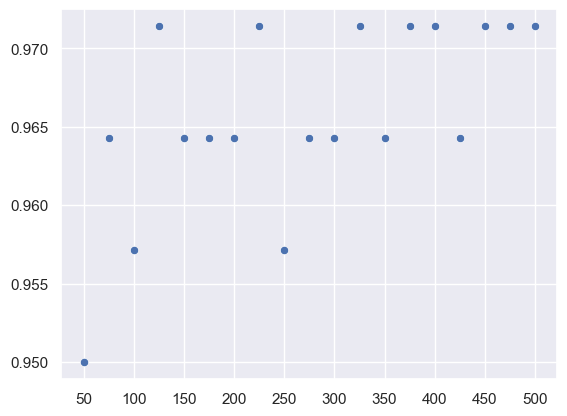

In [41]:
sns.scatterplot(x=range(50, 501, 25), y=plot_scores)
plt.xticks(range(50, 501, 50))

### ExtraTrees


### Zadanie 4
----
Przygotuj model `ExtraTrees` dla danych z Zadania 1.

In [42]:
pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier())
])

In [44]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [4, 5, 6],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline3, param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__min_sampl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=3)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                                       ('classifier', ExtraTreesClassifier())]),
             param_grid={'classifier__max_depth': [4, 5, 6],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [45]:
grid_search.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 50}

In [46]:
grid_search.best_score_

0.9924976095695273

In [47]:
models.append('Extra_Trees')
scores.append(grid_search.score(X_test, y_test))

In [48]:
print(models)
print(scores)

['Bagging_KNN', 'Random_Forest', 'Extra_Trees']
[0.9967251461988305, 0.9941520467836257, 0.9962573099415205]


### Boosting

<img src="boosting.webp"  width="500"/>

*https://medium.com/@brijesh_soni/understanding-boosting-in-machine-learning-a-comprehensive-guide-bdeaa1167a6*

### Zadanie 5
----
Przygotuj model `GradientBoostingClassifier` dla danych z Zadania 1.

In [49]:
pipeline4 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(pipeline4, param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__lea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=3)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [50]:
grid_search.best_params_

{'classifier__learning_rate': 1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 100}

In [51]:
grid_search.best_score_

0.9887678062678062

In [52]:
models.append('Gradient_Boosting')
scores.append(grid_search.score(X_test, y_test))

In [53]:
print(models)
print(scores)

['Bagging_KNN', 'Random_Forest', 'Extra_Trees', 'Gradient_Boosting']
[0.9967251461988305, 0.9941520467836257, 0.9962573099415205, 0.9941520467836257]


### Voting - komitet różnych modeli

### Zadanie 6
----
Przygotuj model wykorzystując funkcję `VoitingClassifier()`. W tym celu wykorzystaj model regresji logistycznej, las losowy i k najbliższych sąsiadów.

In [58]:
pipeline5 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier([
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('knn', KNeighborsClassifier(n_neighbors=11))
    ], voting='soft'))
])

pipeline5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses'],
      dtype='object'))])),
                ('classifier',
                 VotingClassifier(estimators=[('lr', LogisticRegression()),
                                              ('rf', RandomForestClassifier()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=11))],
                                  voting='soft'))])

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pipeline5.predict_proba(X_test)[:, 1])

0.9971929824561403

In [60]:
models.append('Voting')
scores.append(roc_auc_score(y_test, pipeline5.predict_proba(X_test)[:, 1]))

In [61]:
print(models)
print(scores)

['Bagging_KNN', 'Random_Forest', 'Extra_Trees', 'Gradient_Boosting', 'Voting']
[0.9967251461988305, 0.9941520467836257, 0.9962573099415205, 0.9941520467836257, 0.9971929824561403]
